# Homework 9

The goal of this HW is simple. Duplicate (repeat all parts of) homework 8 problem 2 using neural networks. Perform an appropriate contrast of your regression results versus using 

i.) a neural network with 2 hidden nodes and 

ii.) 4 hidden nodes over 2 layers with 2 hidden nodes in each layer. 

All layers should be full connectected, MSE the loss function, a linear output activation layer and RELUs otherwise.

You should return an ipynb nothebook with your code and a final table contrasting the different error rates of the different approaches you tried.

In [1]:
import pandas as pd
import numpy as np
import torch
import statsmodels.formula.api as smf
import statsmodels as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## Read in the data and display rows
df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
# df.head(4)

Consider US as country A and clean the dataset

In [3]:
# Choose a country ('US')
country = 'US'
df_country = df[df['Country/Region'] == country]

df_country = df_country.drop(columns=['Lat', 'Long'])

# Sum cases across different provinces/states for the US
df_country = df_country.sum(numeric_only=True, axis=0)

# Convert the series to a DataFrame and reset the index
df_country = pd.DataFrame(df_country).reset_index()
df_country.columns = ['Date', 'Cases']

# Convert from Cumulative to Daily Cases
covid_data_daily = df_country['Cases'].diff()
df_country['Daily'] = covid_data_daily

# Reset the index to represent days since the outbreak onset (t=0)
df_country = df_country.reset_index(drop=True)

# Create lagged variables (up to 5 days) -- note the lagged case variables refer to daily case counts
for i in range(1, 6):
    df_country[f'Cases_lag{i}'] = df_country['Daily'].shift(i)

# Drop rows with NaN values caused by lagging
df_country = df_country.dropna()
df_country.head()

# Define dependent and independent variables
y = df_country['Daily']
X = df_country[['Cases_lag1', 'Cases_lag2', 'Cases_lag3', 'Cases_lag4', 'Cases_lag5']]

In [4]:
print(df_country.columns)

Index(['Date', 'Cases', 'Daily', 'Cases_lag1', 'Cases_lag2', 'Cases_lag3',
       'Cases_lag4', 'Cases_lag5'],
      dtype='object')


In [5]:
print(X.head())

    Cases_lag1  Cases_lag2  Cases_lag3  Cases_lag4  Cases_lag5
6          0.0         3.0         0.0         1.0         0.0
7          0.0         0.0         3.0         0.0         1.0
8          1.0         0.0         0.0         3.0         0.0
9          0.0         1.0         0.0         0.0         3.0
10         2.0         0.0         1.0         0.0         0.0


First, consider the whole dataset

In [7]:
std_data = pd.DataFrame(columns=df_country.iloc[:,2:].columns,index=range(len(df_country)))
for i in range(std_data.shape[1]):
    # get each predictor
    vector = df_country.iloc[:,2+i]
    # mean of each predictor
    me =np.mean(vector)
    # standard deviation
    sd = np.std(vector)
    # standardize the predictor
    new = (vector- me)/sd
    new = np.reshape(new, -1)
    std_data.iloc[:,i] = new

In [8]:
print(std_data.head(5))

      Daily Cases_lag1 Cases_lag2 Cases_lag3 Cases_lag4 Cases_lag5
0 -0.720833  -0.720382  -0.719757  -0.719433  -0.719336  -0.719385
1 -0.720825  -0.720382  -0.719781  -0.719409  -0.719344  -0.719377
2 -0.720833  -0.720374  -0.719781  -0.719433  -0.719321  -0.719385
3 -0.720818  -0.720382  -0.719773  -0.719433  -0.719344  -0.719362
4 -0.720833  -0.720366  -0.719781  -0.719425  -0.719344  -0.719385


In [9]:
n = len(df_country)
# change DF to numpy.array and then to tensor
std_y = torch.from_numpy(std_data['Daily'].astype(float).to_numpy())
std_X = torch.from_numpy(std_data.iloc[:,1:].astype(float).to_numpy())

# change to float
std_y = std_y.float()
std_X = std_X.float()

# change the shape of Y from [1137]-->[1137,1]
std_y = std_y.unsqueeze(1)

print(f"std_y shape: {std_y.shape}")
print(f"std_X shape: {std_X.shape}")
print(f"n: {n}")

std_y shape: torch.Size([1137, 1])
std_X shape: torch.Size([1137, 5])
n: 1137


In [10]:
# Build a neural network model with two hidden nodes
model = torch.nn.Sequential(
    torch.nn.Linear(5, 2),
    torch.nn.ReLU(),
    torch.nn.Linear(2, 1),
)
print(model)
print("displaying parameters ",
      list(model.parameters()))  # why it has output already? is this randomly assigned? not sure about the number of parameters

# loss function
loss_fn = torch.nn.MSELoss(reduction='sum')

#set the optimizer
optimizer = torch.optim.SGD(model.parameters(),lr=1e-4)

# loop over iterations
for t in range(10000):
    # foward propagation
    y_pred = model(std_X)

    # the loss for this itneration
    loss = loss_fn(y_pred, std_y)
    if t % 1000 == 999:
        print(t, loss)   # why sometimes it is NA; every time is different? Should consider which one?

    # Zero out the gradient 
    optimizer.zero_grad()

    # Backprop
    loss.backward()

  # Optimization step
    optimizer.step()

# present the final parameters
for param in model.parameters():
    print(param)

Sequential(
  (0): Linear(in_features=5, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=1, bias=True)
)
displaying parameters  [Parameter containing:
tensor([[-0.2393, -0.4361, -0.2947, -0.1724, -0.0010],
        [ 0.4314,  0.1143,  0.2829,  0.1813,  0.3033]], requires_grad=True), Parameter containing:
tensor([-0.4412, -0.0174], requires_grad=True), Parameter containing:
tensor([[-0.5980,  0.3065]], requires_grad=True), Parameter containing:
tensor([0.6269], requires_grad=True)]


999 tensor(267.0924, grad_fn=<MseLossBackward0>)
1999 tensor(266.9927, grad_fn=<MseLossBackward0>)
2999 tensor(266.9927, grad_fn=<MseLossBackward0>)
3999 tensor(266.9927, grad_fn=<MseLossBackward0>)
4999 tensor(266.9926, grad_fn=<MseLossBackward0>)
5999 tensor(266.9927, grad_fn=<MseLossBackward0>)
6999 tensor(266.9927, grad_fn=<MseLossBackward0>)
7999 tensor(266.9927, grad_fn=<MseLossBackward0>)
8999 tensor(266.9927, grad_fn=<MseLossBackward0>)
9999 tensor(266.9926, grad_fn=<MseLossBackward0>)
Parameter containing:
tensor([[-0.9530,  0.2289, -0.0410,  0.1109, -0.5149],
        [ 0.6692,  0.0166,  0.4235,  0.2966, -0.0410]], requires_grad=True)
Parameter containing:
tensor([ 0.0503, -0.2357], requires_grad=True)
Parameter containing:
tensor([[-1.0112,  0.6841]], requires_grad=True)
Parameter containing:
tensor([0.1560], requires_grad=True)


In [11]:
std_y_pred = model(std_X)
std_y_pred = y_pred.detach().numpy().reshape(-1)
# change tensor to numpy.array
std_y = std_y.numpy().reshape(-1)
# Compute residuals
std_res_full = std_y - std_y_pred

In [ ]:
# Build a class for the neuro network
import torch
class oneLayer(torch.nn.Module):
    def __init__(self):
        super(oneLayer, self).__init__()

        self.linear1 = torch.nn.Linear(5,2)
        self.ReLU = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(2,1)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.ReLU(x)
        x = self.linear2(x)
        return x

model = oneLayer()
print(model)

print(list(model.parameters()))

oneLayer(
  (linear1): Linear(in_features=5, out_features=2, bias=True)
  (ReLU): ReLU()
  (linear2): Linear(in_features=2, out_features=1, bias=True)
)
[Parameter containing:
tensor([[ 0.4369,  0.1857, -0.1868,  0.2123,  0.4360],
        [-0.1900, -0.4281,  0.1158,  0.0933,  0.1216]], requires_grad=True), Parameter containing:
tensor([-0.2462, -0.1632], requires_grad=True), Parameter containing:
tensor([[-0.4265, -0.0561]], requires_grad=True), Parameter containing:
tensor([0.6643], requires_grad=True)]


In [12]:
std_data2 = pd.DataFrame(columns=df_country.iloc[:,2:].columns,index=range(len(df_country)))
for i in range(std_data2.shape[1]):
    # get each predictor
    vector = df_country.iloc[:,2+i]
    # mean of each predictor
    me =np.mean(vector)
    # standard deviation
    sd = np.std(vector)
    # standardize the predictor
    new = (vector- me)/sd
    new = np.reshape(new, -1)
    std_data2.iloc[:,i] = new

In [13]:
# change DF to numpy.array and then to tensor
std_y2 = torch.from_numpy(std_data2['Daily'].astype(float).to_numpy())
std_X2 = torch.from_numpy(std_data2.iloc[:,1:].astype(float).to_numpy())

# change to float
std_y2 = std_y2.float()
std_X2 = std_X2.float()

# change the shape of Y from [1137]-->[1137,1]
std_y2 = std_y2.unsqueeze(1)

print(f"std_y2 shape: {std_y2.shape}")
print(f"std_X2 shape: {std_X2.shape}")
print(f"n: {n}")

std_y2 shape: torch.Size([1137, 1])
std_X2 shape: torch.Size([1137, 5])
n: 1137


In [14]:
# Build a neural network model with two hidden nodes
model = torch.nn.Sequential(
    torch.nn.Linear(5, 2),
    torch.nn.ReLU(),
    torch.nn.ReLU(),
    torch.nn.Linear(2, 1),
)

print("displaying parameters ",
      list(model.parameters()))  # why it has output already? is this randomly assigned?

#loss function
loss_fn = torch.nn.MSELoss(reduction='sum')

#set the optimizer
optimizer = torch.optim.SGD(model.parameters(),lr=1e-4)

# loop over iterations
for t in range(10000):
    # foward propagation
    y_pred2 = model(std_X2)

    # the loss for this itneration
    loss = loss_fn(y_pred2, std_y2)
    if t % 1000 == 999:
        print(t, loss)   # why sometimes it is NA; every time is different? Should consider which one?

    ## Zero out the gradient before adding them up [before we do the back propagation step]
    ## when we accumulate with a back propagation step, it does not add to the previous value.
    optimizer.zero_grad()

    ## Backprop
    loss.backward()

  ## Optimization step
    optimizer.step()


for param in model.parameters():
    print(param)


displaying parameters  [Parameter containing:
tensor([[-0.0481, -0.4092, -0.2030, -0.2093,  0.2902],
        [ 0.2754, -0.2295, -0.0233, -0.2237, -0.3116]], requires_grad=True), Parameter containing:
tensor([ 0.3143, -0.0198], requires_grad=True), Parameter containing:
tensor([[-0.3072, -0.4272]], requires_grad=True), Parameter containing:
tensor([0.5383], requires_grad=True)]


999 tensor(591.7722, grad_fn=<MseLossBackward0>)
1999 tensor(672.4886, grad_fn=<MseLossBackward0>)
2999 tensor(666.5941, grad_fn=<MseLossBackward0>)
3999 tensor(412.3725, grad_fn=<MseLossBackward0>)
4999 tensor(732.0897, grad_fn=<MseLossBackward0>)
5999 tensor(479.2090, grad_fn=<MseLossBackward0>)
6999 tensor(463.2089, grad_fn=<MseLossBackward0>)
7999 tensor(808.1619, grad_fn=<MseLossBackward0>)
8999 tensor(677.6388, grad_fn=<MseLossBackward0>)
9999 tensor(627.8918, grad_fn=<MseLossBackward0>)
Parameter containing:
tensor([[-0.2228, -0.1224, -0.1516, -0.1285, -0.1564],
        [-1.8314,  0.9762,  0.0639,  0.3337, -0.3756]], requires_grad=True)
Parameter containing:
tensor([ 2.0640, -0.5372], requires_grad=True)
Parameter containing:
tensor([[-1.8602, -0.7716]], requires_grad=True)
Parameter containing:
tensor([3.4862], requires_grad=True)


In [15]:
std_y_pred2 = model(std_X2)
std_y_pred2 = y_pred2.detach().numpy().reshape(-1)
# change tensor to numpy.array
std_y2 = std_y2.numpy().reshape(-1)
# Compute residuals
std_res_full2 = std_y2 - std_y_pred2

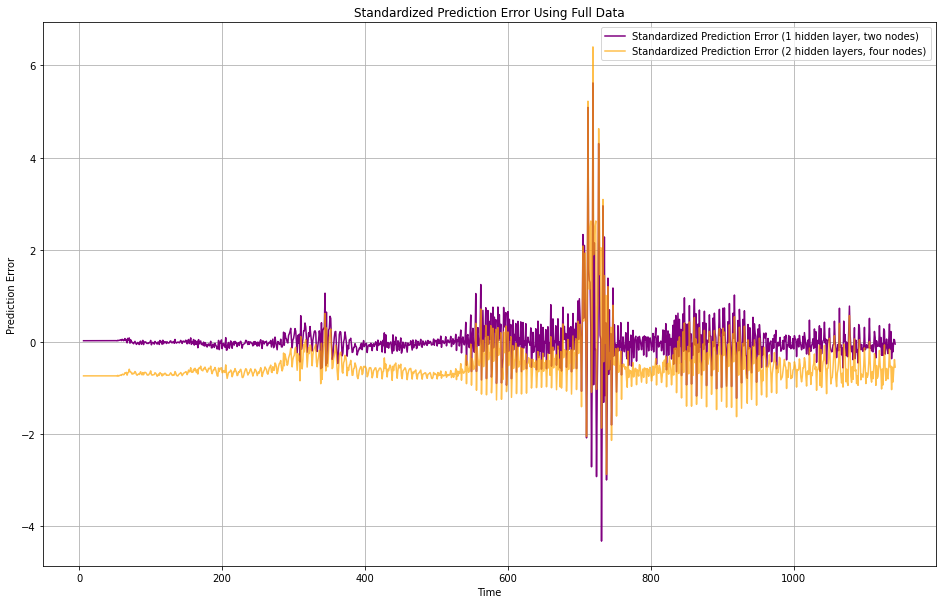

In [16]:
# Create two subplots 1) 1 hidden layer, two nodes 2) 2 hidden layers, four nodes
plt.figure(figsize=(16, 10))
plt.plot(X.index,std_res_full, label='Standardized Prediction Error (1 hidden layer, two nodes)',color='purple')
plt.plot(X.index,std_res_full2, label='Standardized Prediction Error (2 hidden layers, four nodes)',color='Orange', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Prediction Error')
plt.title('Standardized Prediction Error Using Full Data')
plt.legend()
plt.grid(True)
plt.show();

Use half as training and half as validation

In [17]:
### (b) Train on first half, test on second half
half_n = len(df_country) // 2

# First half
X_train = X.iloc[:half_n]
y_train = y.iloc[:half_n]

# Second half
X_test = X.iloc[half_n:]
y_test = y.iloc[half_n:]